### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

## data load

#### train & test dataset load

In [2]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
df.head(3)

,ID,target,_type
0,2023-01-01 00:00:00,2.0,train
1,2023-01-01 01:00:00,1.0,train
2,2023-01-01 02:00:00,1.0,train


**level1_project**  

주제 : 비트코인 상승/하락 시계열 예측 프로젝트
- target : 0,1,2,3 -> 0 : 대폭 하락, 1 : 소폭 하락, 2 : 소폭 상승, 3 : 대폭 상승
- train:test = 8:2 
-> train data : 2023/01/01 00:00 ~ 2023/12/31 23:00 (1시간 간격)
-> test data : 2024/01/01 00:00 ~ 2024/04/26 07:00
- columns : 255개


#### seperate file type

In [4]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할당
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 30.39it/s]


In [5]:
market_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_MARKET") and f.endswith(".csv")
]
newwork_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_NETWORK") and f.endswith(".csv")
]

In [6]:
# 거래소 종류(총 8개의 거래소)
# 각 마케팅 타입 종류(종류별 거래소 정보 존재)
exchange_name = ['BINANCE','BITMEX','BYBIT','DERIBIT','HTX_GLOBAL','HUOBI_GLOBAL','OKEX','OKX']
market_type_name = ['FUNDING-RATES','LIQUIDATIONS','OEPN-INTEREST','TAKER-BUY-SELL-STATS']

## EDA

In [7]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_liquidations_okex_btc_usdt_long_liquidations                 100.0
hourly_market-data_liquidations_okex_btc_usdt_short_liquidations                100.0
hourly_market-data_liquidations_okex_btc_usdt_long_liquidations_usd             100.0
hourly_market-data_open-interest_kraken_open_interest                           100.0
hourly_market-data_liquidations_ftx_all_symbol_long_liquidations                100.0
                                                                                ...  
hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations          0.0
hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd       0.0
hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd      0.0
target                                                                            0.0
ID                                                                                0.0
Length: 255, dtype: float64

In [8]:
# 100.0인 값들만 필터링
missing_100_columns = sorted_missing_percentage[sorted_missing_percentage == 100.0].index.tolist()
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
print(len(missing_100_columns), len(non_missing_columns))
print(missing_100_columns)

40 215
['hourly_market-data_liquidations_okex_btc_usdt_long_liquidations', 'hourly_market-data_liquidations_okex_btc_usdt_short_liquidations', 'hourly_market-data_liquidations_okex_btc_usdt_long_liquidations_usd', 'hourly_market-data_open-interest_kraken_open_interest', 'hourly_market-data_liquidations_ftx_all_symbol_long_liquidations', 'hourly_market-data_liquidations_ftx_all_symbol_short_liquidations', 'hourly_market-data_liquidations_ftx_all_symbol_long_liquidations_usd', 'hourly_market-data_open-interest_all_exchange_open_interest', 'hourly_market-data_open-interest_huobi_global_open_interest', 'hourly_market-data_liquidations_okex_all_symbol_long_liquidations', 'hourly_market-data_liquidations_okex_all_symbol_short_liquidations', 'hourly_market-data_liquidations_okex_all_symbol_long_liquidations_usd', 'hourly_market-data_liquidations_okex_all_symbol_short_liquidations_usd', 'hourly_market-data_open-interest_ftx_open_interest', 'hourly_market-data_open-interest_okex_open_interest',

### market data

#### target에 따른 각 column별 분포 확인

In [38]:
def target_column_relationship(df, column):
    rel_df = df[['ID',f'{column}','target']]

    class_counts = rel_df['target'].value_counts()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=rel_df, x='ID', y=f'{column}', hue='target')
    plt.title(f'Line Plot of {column} Over Time with Target', fontsize=16)
    plt.xlabel('Time')
    plt.legend(title='Target')

    # x축에 첨과 끝, 중간 레이블만 표시
    xticks = [rel_df['ID'][0], rel_df['ID'][len(rel_df) // 2], rel_df['ID'][len(rel_df)-1]]
    plt.xticks(xticks)
    plt.show()

    return class_counts


#### open_interest  
1. 총 28개의 관련 변수 존재  
2. 아래의 그래프를 확인하면 알 수 있듯이 전체적으로 4개의 class가 동일한 분포를 형성하고 있음
3. target의 분포는 대부분 1(소폭 하락), 2(소폭 상승)에 2배 3000개정도의 데이터씩 보유하고 있고 나머지 0(대폭 하락)과 3(대폭 상승)에는 1000개 이하의 데이터를 보유하고 있음

In [46]:
open_interest_columns = [column for column in non_missing_columns if 'open_interest' in column]
print(len(open_interest_columns))

28


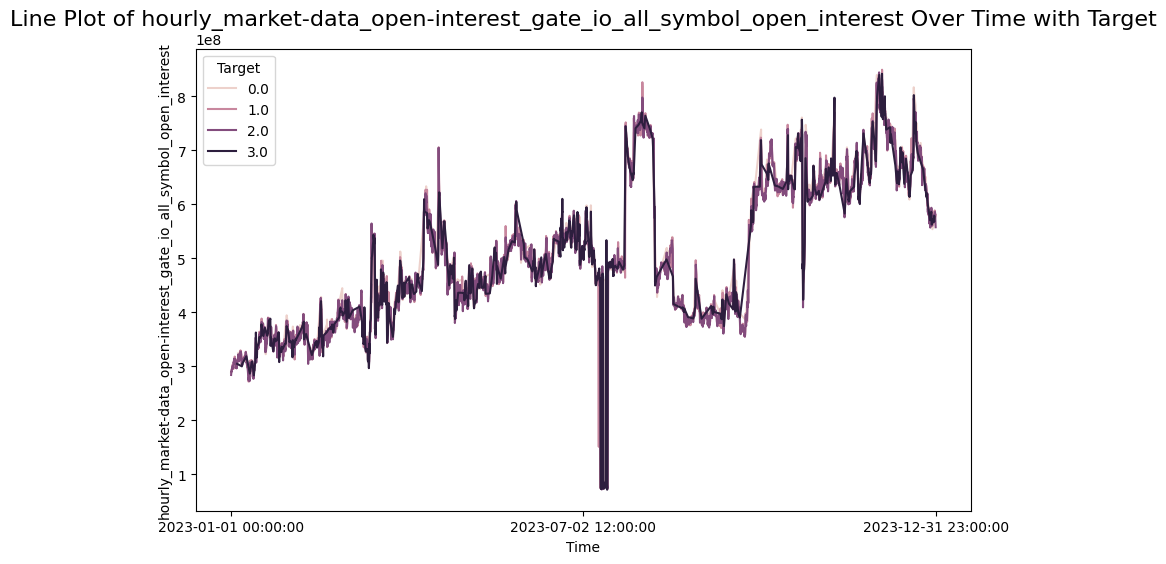

target
2.0    3671
1.0    3544
3.0     805
0.0     740
Name: count, dtype: int64

In [47]:
target_column_relationship(eda_df, open_interest_columns[13])

#### funding_rate
1. 총 8개의 변수 존재

In [43]:
funding_rate_columns = [column for column in non_missing_columns if 'funding_rate' in column]
print(len(funding_rate_columns))

8


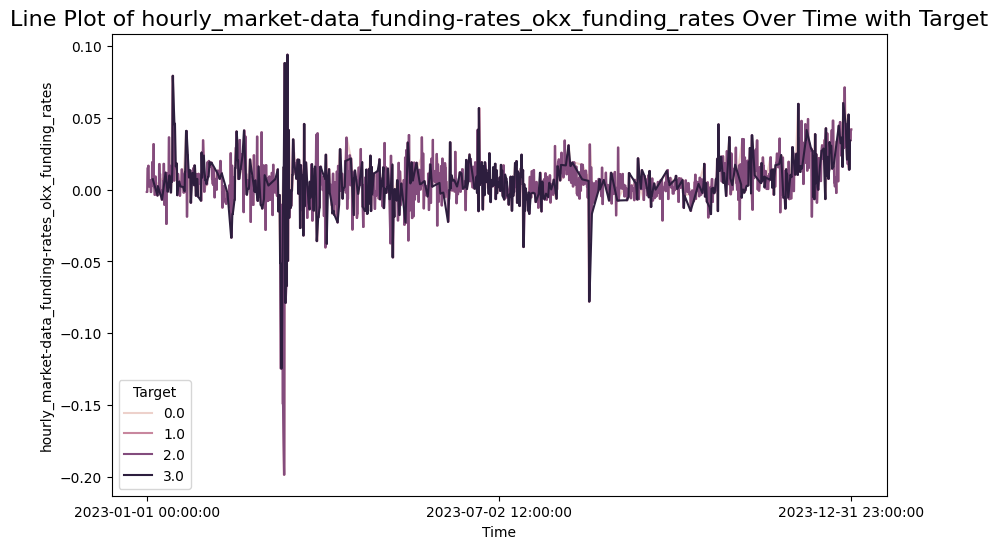

target
2.0    3671
1.0    3544
3.0     805
0.0     740
Name: count, dtype: int64

In [45]:
target_column_relationship(eda_df, funding_rate_columns[3])

#### liquidations

### coinbase_premium-index

In [60]:
file_name = 'HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv'
cpi = pd.read_csv(os.path.join(data_path,file_name))
new_cpi = pd.merge()

,datetime,coinbase_premium_gap,coinbase_premium_index
0,2024-04-26 06:00:00,-2.05,-0.003184
1,2024-04-26 05:00:00,1.85,0.002866
2,2024-04-26 04:00:00,-11.73,-0.018268
3,2024-04-26 03:00:00,-1.53,-0.002376
4,2024-04-26 02:00:00,2.70,0.004186
...,...,...,...
58491,2017-08-17 08:00:00,-4.99,-0.114431
58492,2017-08-17 07:00:00,-9.99,-0.229656
58493,2017-08-17 06:00:00,-14.35,-0.331842
58494,2017-08-17 05:00:00,-0.52,-0.012050


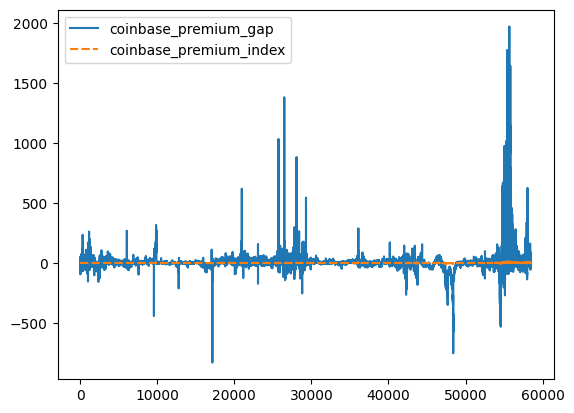

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(cpi)
plt.show()

##### funding_rates

In [103]:
funding_rates_list = [column for column in eda_df.columns if 'funding' in column]  

['hourly_market-data_funding-rates_bitmex_funding_rates_x',
 'hourly_market-data_funding-rates_okx_funding_rates_x',
 'hourly_market-data_funding-rates_bybit_funding_rates_x',
 'hourly_market-data_funding-rates_binance_funding_rates_x',
 'hourly_market-data_funding-rates_okex_funding_rates_x',
 'hourly_market-data_funding-rates_htx_global_funding_rates_x',
 'hourly_market-data_funding-rates_deribit_funding_rates_x',
 'hourly_market-data_funding-rates_all_exchange_funding_rates_x',
 'hourly_market-data_funding-rates_huobi_global_funding_rates_x',
 'hourly_market-data_funding-rates_bitmex_funding_rates_y',
 'hourly_market-data_funding-rates_okx_funding_rates_y',
 'hourly_market-data_funding-rates_bybit_funding_rates_y',
 'hourly_market-data_funding-rates_binance_funding_rates_y',
 'hourly_market-data_funding-rates_okex_funding_rates_y',
 'hourly_market-data_funding-rates_htx_global_funding_rates_y',
 'hourly_market-data_funding-rates_deribit_funding_rates_y',
 'hourly_market-data_funding

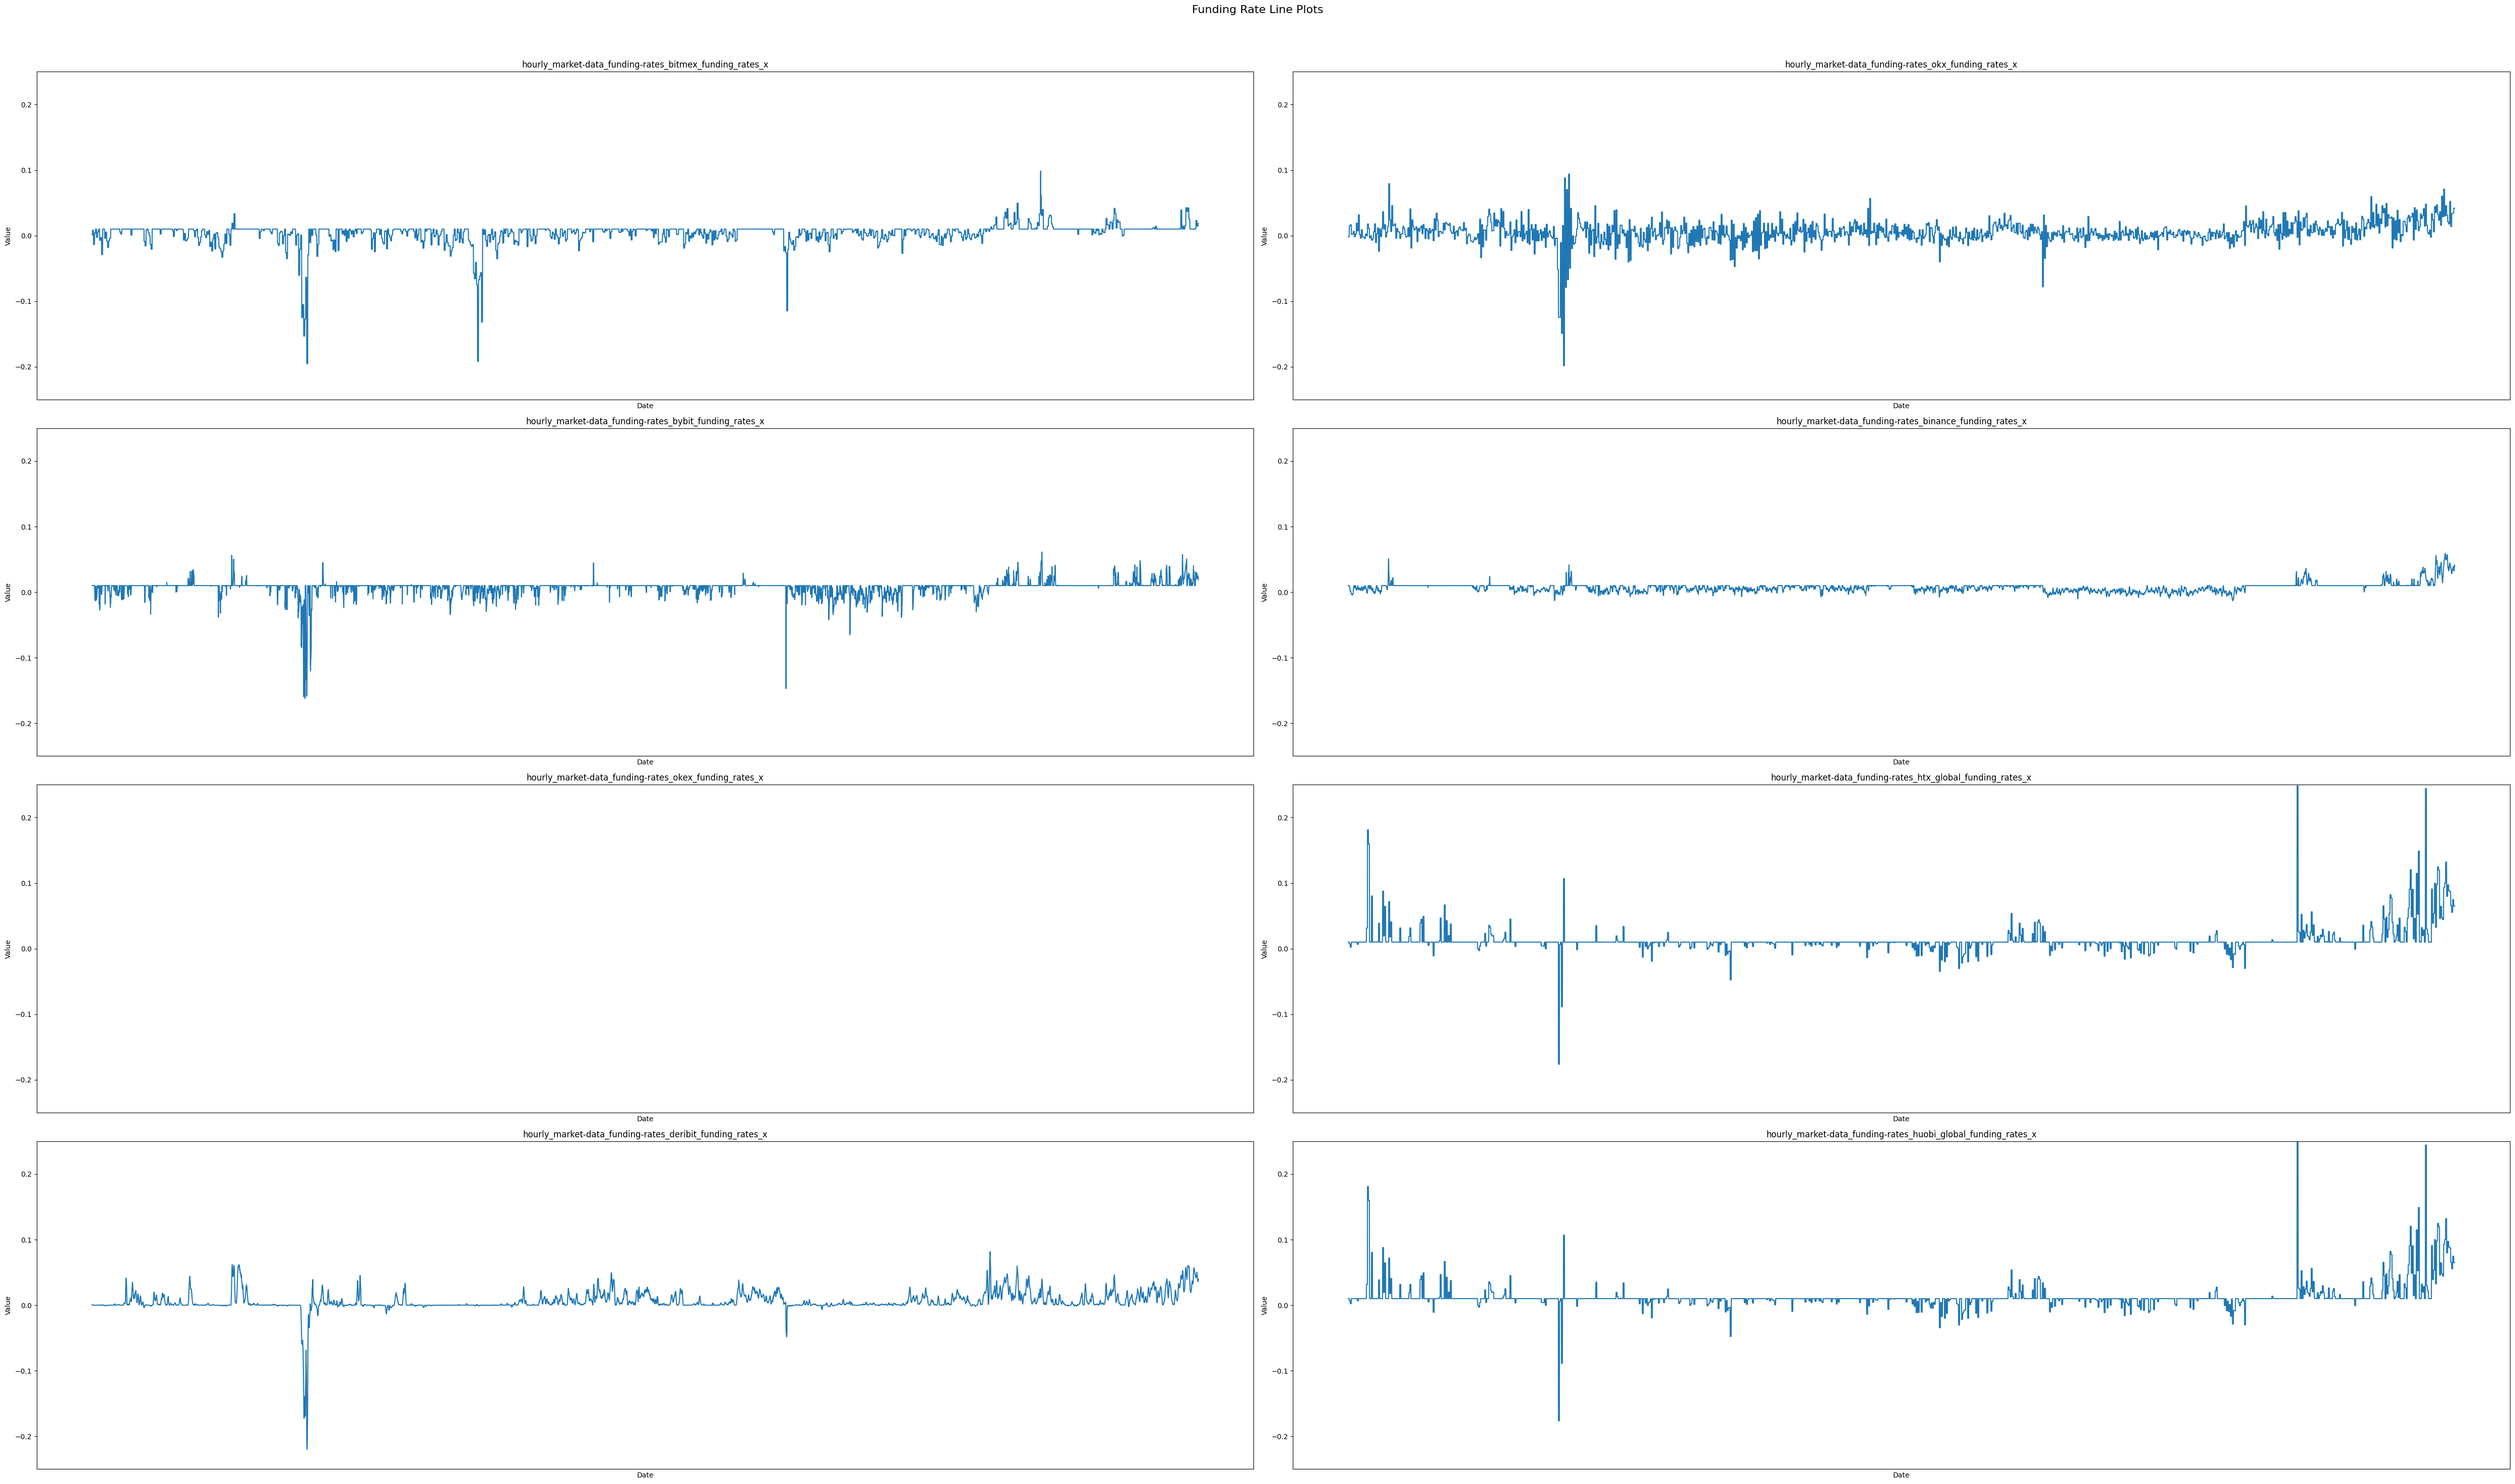

In [127]:
def funding_rate_line_plot(ax, column, y_lim):
    df = eda_df[['ID', column]]
    sns.lineplot(x='ID', y=column, data=df, ax=ax)
    ax.set_xticks([])  # X축 눈금 제거
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'{column}')
    ax.set_ylim(y_lim)  # Y축 범위 설정

fig, axes = plt.subplots(4 ,2, figsize=(50, 30))
fig.suptitle('Funding Rate Line Plots', fontsize=16)

# 컬럼 리스트
columns = [
    'hourly_market-data_funding-rates_bitmex_funding_rates_x',
    'hourly_market-data_funding-rates_okx_funding_rates_x',
    'hourly_market-data_funding-rates_bybit_funding_rates_x',
    'hourly_market-data_funding-rates_binance_funding_rates_x',
    'hourly_market-data_funding-rates_okex_funding_rates_x',
    'hourly_market-data_funding-rates_htx_global_funding_rates_x',
    'hourly_market-data_funding-rates_deribit_funding_rates_x',
    'hourly_market-data_funding-rates_huobi_global_funding_rates_x',
    ]

y_lim = (-0.25, 0.25)

# 각 subplot에 함수 적용
for i, ax in enumerate(axes.flat):
    funding_rate_line_plot(ax, columns[i], y_lim)

# 그래프 간 여백을 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목과 겹치지 않도록 여백 설정

# 그래프 보여주기
plt.show()